# LSTM for Predicting PV energy generation   

In [1]:
# Data handling and manipulation
import pandas as pd
import numpy as np

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Plotting and visualization
import matplotlib.pyplot as plt

In [2]:
# Step 1: Load the dataset
file_path = 'solar_data_with_temperature_adjusted_irradiance.csv'
data = pd.read_csv(
    file_path,
    index_col=[0],  # Use 'time' as the index
    parse_dates=[0]  # Parse the 'time' column as datetime
).drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])


In [3]:
split = data.index[int(len(data) * 0.7)]

train = data.loc[data.index <= split].copy()
test = data.loc[data.index > split].copy()


In [4]:
def create_features(data, label = None):
    # Step 2: Separate the features (X) and the target (y)
    X = data[['GHI', 'DNI', 'DHI', 'Temperature']]  # Features
    if label:
        y = data[label]
        return X, y
    return X

X_train, y_train = create_features(train, label='Tilted Irradiance (Adjusted)')
X_test, y_test = create_features(test, label='Tilted Irradiance (Adjusted)')




In [5]:
# Step 6: Apply ColumnTransformer for preprocessing to the dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['GHI', 'DNI', 'DHI', 'Temperature']),  # Scale numerical features
    ]
)

In [10]:
# %% [code]
# Step 3: Feature creation (this part stays the same)
def create_features(data, label=None):
    X = data[['GHI', 'DNI', 'DHI', 'Temperature']]  # Features
    if label:
        y = data[label]  # Target variable
        return X, y
    return X

X_train, y_train = create_features(train, label='Tilted Irradiance (Adjusted)')
X_test, y_test = create_features(test, label='Tilted Irradiance (Adjusted)')

# %% [code]
# Step 4: Apply preprocessing using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), ['GHI', 'DNI', 'DHI', 'Temperature'])]  # Scaling numerical features
)

# Transform X_train and X_test without converting to numpy arrays
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# %% [code]
# Step 5: Reshape the data for LSTM
# LSTM requires the input data to be 3D, with shape (samples, time_steps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])  # 1 timestep
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])  # 1 timestep

# %% [code]
# Step 6: Define the LSTM model
def lstm_model(xtrain, ytrain):
    """
    Builds and trains an LSTM model using the training data.

    Parameters:
        xtrain (np.ndarray): Input training data.
        ytrain (np.ndarray): Target training data.

    Returns:
        Sequential: Trained LSTM model.
    """
    model = Sequential()
    # 1st Layer
    model.add(LSTM(units=50, activation='relu',
                  return_sequences=True, input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    # 2nd Layer
    model.add(LSTM(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    # 3rd Layer
    model.add(LSTM(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    # 4th Layer
    model.add(LSTM(units=120, activation='relu'))  # Output layer without return_sequences
    model.add(Dropout(0.5))

    model.add(Dense(units=1))  # Output layer for single prediction
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(xtrain, ytrain, epochs=50, batch_size=32)

    return model

# %% [code]
# Step 7: Train the LSTM model on the training data
model = lstm_model(X_train_scaled, y_train)

# Step 8: Make predictions on the test data
test['Prediction'] = model.predict(X_test_scaled)



c:\Users\giuli\Repositories\aee_2425\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 113261.2891
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10982.1748
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7411.5635
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6052.4858
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5720.3257
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5665.7173
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5133.8916
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5167.3296
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4968.4434
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5032.2373
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4986.3247
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5203.8384
Epoch 13/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4589.3721
Epoch 14/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5010.2847
Epoch 15/50


In [11]:
all = pd.concat([test, train], sort = False)

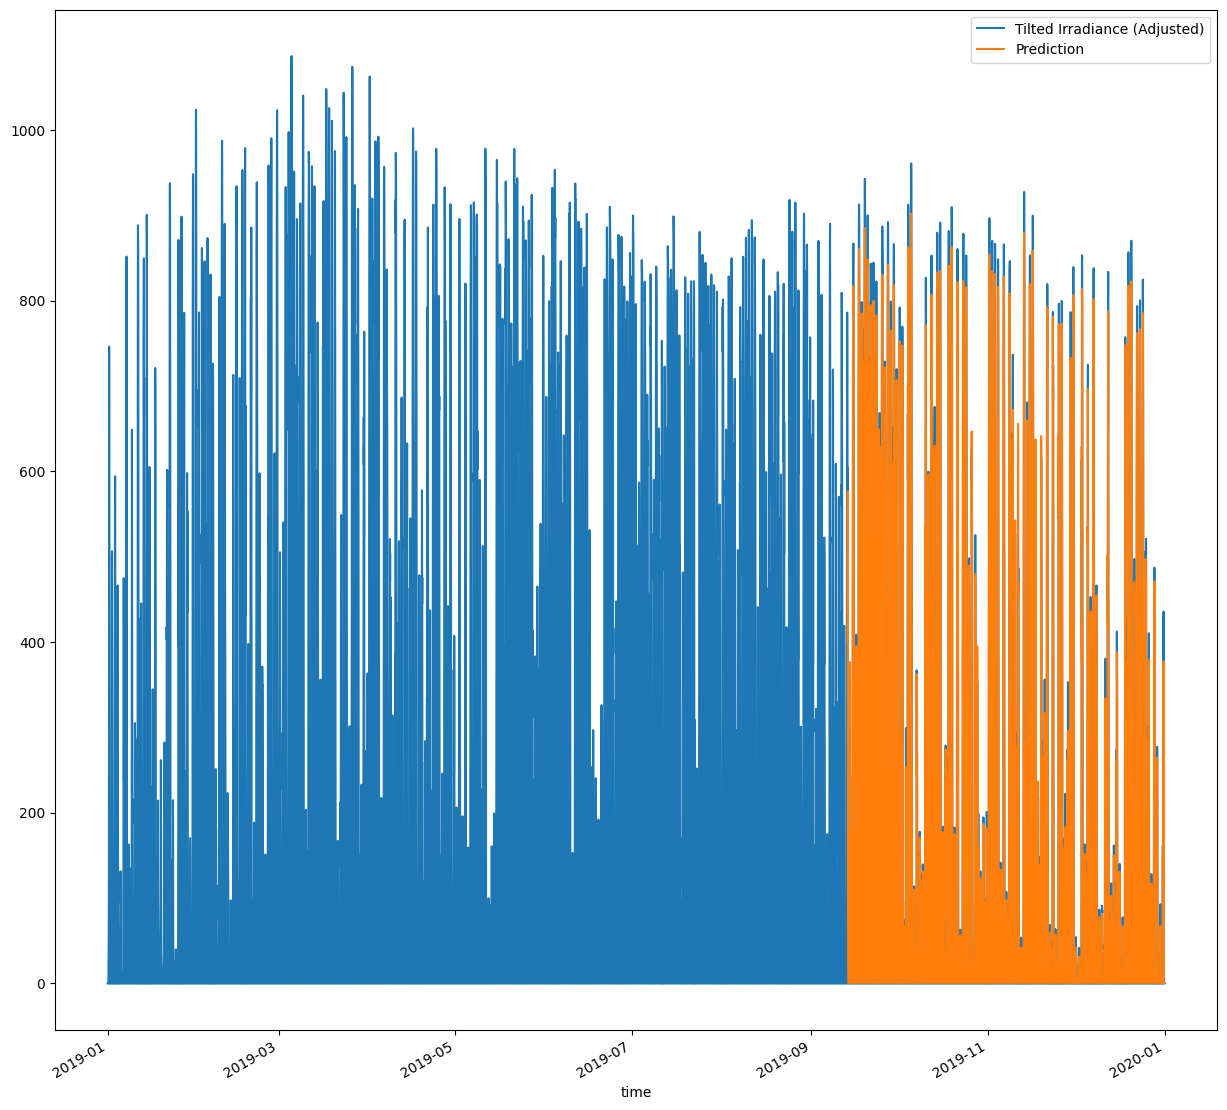

In [12]:
_ = all[['Tilted Irradiance (Adjusted)', 'Prediction']].plot(figsize=(15,15))




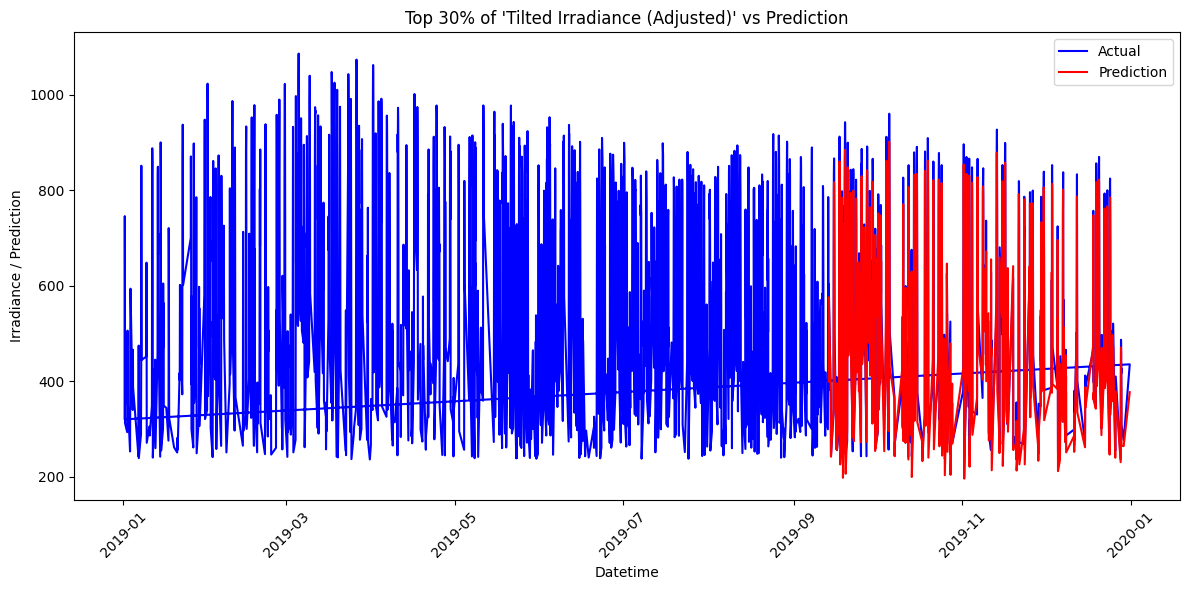

In [13]:
# Step 1: Calculate the threshold for the top 10% of 'Tilted Irradiance (Adjusted)'
top_10_percent_threshold = all['Tilted Irradiance (Adjusted)'].quantile(0.70)

# Step 2: Filter the data to only include the top 10% based on 'Tilted Irradiance (Adjusted)'
top_10_percent_data = all[all['Tilted Irradiance (Adjusted)'] >= top_10_percent_threshold]

# Step 3: Plot the filtered data as a line plot for actual and predicted data
plt.figure(figsize=(12, 6))

# Plot the actual data (blue)
plt.plot(top_10_percent_data.index, top_10_percent_data['Tilted Irradiance (Adjusted)'], label='Actual', color='blue')

# Plot the predicted data (red)
plt.plot(top_10_percent_data.index, top_10_percent_data['Prediction'], label='Prediction', color='red')

# Optional: Add titles, labels, and a legend
plt.title("Top 30% of 'Tilted Irradiance (Adjusted)' vs Prediction")
plt.xlabel("Datetime")  # or "Index" if the index is not datetime
plt.ylabel("Irradiance / Prediction")
plt.legend()

# Rotate x-axis labels if necessary for readability
plt.xticks(rotation=45)

# Show the plot with tight layout for spacing
plt.tight_layout()
plt.show()


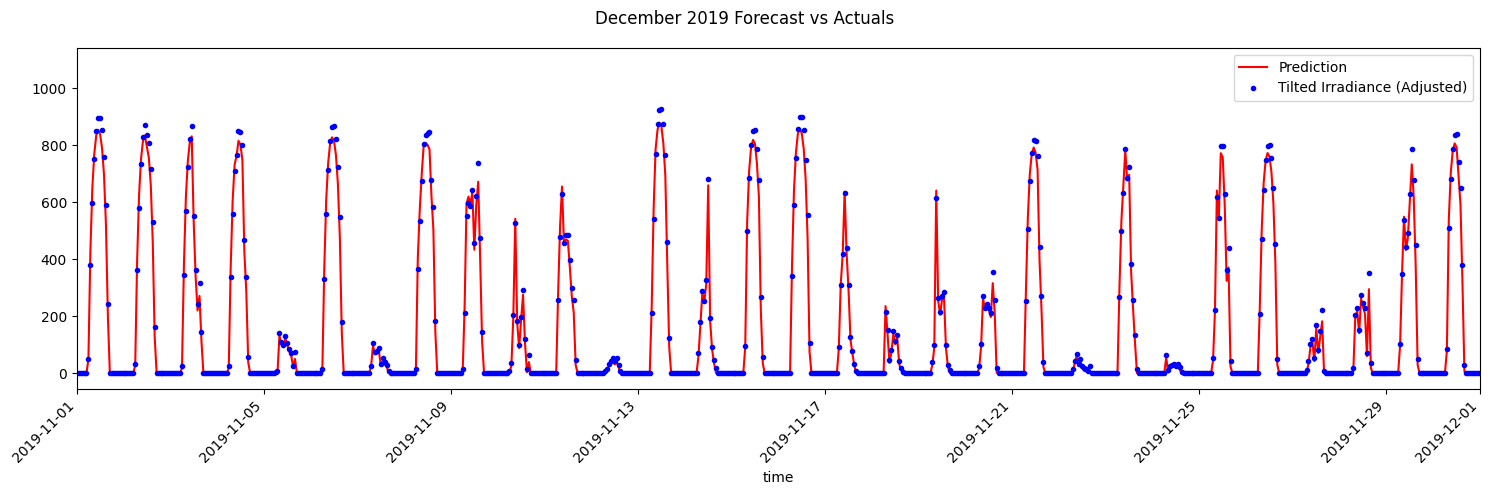

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot actual vs predicted MW values, with distinct line styles
_ = all[['Prediction', 'Tilted Irradiance (Adjusted)']].plot(ax=ax,
                                                style=['-', '.'],
                                                color=['red', 'blue'])  # Red for Prediction, Blue for Actuals

# Set x-axis bounds to zoom in on January 2015
ax.set_xlim(pd.to_datetime('2019-11-01'), pd.to_datetime('2019-12-01'))

# Set y-axis limits to match the range from 0 to 60000
#ax.set_ylim(0, 60000)

# Add a title for the plot
plt.suptitle('December 2019 Forecast vs Actuals')

# Optional: Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred, handling zero values in y_true."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Mask where y_true is zero or NaN
    valid_mask = (y_true != 0) & ~np.isnan(y_true)
    
    # Apply the mask to both y_true and y_pred
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]
    
    # If there are no valid points, return NaN or some other indicator (e.g., inf)
    if len(y_true_valid) == 0:
        return np.nan
    
    # Calculate the MAPE only on valid (non-zero, non-NaN) values
    mape = np.mean(np.abs((y_true_valid - y_pred_valid) / y_true_valid)) * 100
    
    return mape

# Example usage:
mape_value = mean_absolute_percentage_error(y_true=test['Tilted Irradiance (Adjusted)'], y_pred=test['Prediction'])
print(f"MAPE: {mape_value:.2f}%")

# Your true and predicted values
y_true = test['Tilted Irradiance (Adjusted)']
y_pred = test['Prediction']

# Ensure that both y_true and y_pred are arrays or series of the same length
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# R-squared (R²) - how well the model explains the variance
r2 = r2_score(y_true, y_pred)
print(f"R-squared (R²): {r2:.2f}")



MAPE: 16.21%
Mean Absolute Error (MAE): 10.18
Mean Squared Error (MSE): 385.89
Root Mean Squared Error (RMSE): 19.64
R-squared (R²): 0.99
